# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np

from surprise import Dataset, Reader
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse, fcp
from surprise.model_selection import cross_validate, train_test_split

In [2]:
artist_data = pd.read_csv("./data/lastfm/artists.dat", sep="\t")
artist_data.head()

id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...

In [3]:
user_artist_plays = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983

In [4]:
user_artist_plays_data = user_artist_plays.join(artist_data.set_index('id'), on='artistID')
user_artist_plays_data.head()
#len(user_artist_plays_data)

userID  artistID  weight           name  \
0       2        51   13883    Duran Duran   
1       2        52   11690      Morcheeba   
2       2        53   11351            Air   
3       2        54   10300   Hooverphonic   
4       2        55    8983  Kylie Minogue   

                                      url  \
0    http://www.last.fm/music/Duran+Duran   
1      http://www.last.fm/music/Morcheeba   
2            http://www.last.fm/music/Air   
3   http://www.last.fm/music/Hooverphonic   
4  http://www.last.fm/music/Kylie+Minogue   

                                          pictureURL  
0   http://userserve-ak.last.fm/serve/252/155668.jpg  
1  http://userserve-ak.last.fm/serve/252/46005111...  
2   http://userserve-ak.last.fm/serve/252/251119.jpg  
3  http://userserve-ak.last.fm/serve/252/40553471...  
4  http://userserve-ak.last.fm/serve/252/12740835...

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [5]:
n_artist = user_artist_plays_data['artistID'].nunique()
n_users = user_artist_plays_data['userID'].nunique()

print(f"Number of unique users: {n_users}")
print(f"Number of unique artists: {n_artist}")

Number of unique users: 1892
Number of unique artists: 17632


Text(0, 0.5, 'Reproducciones')

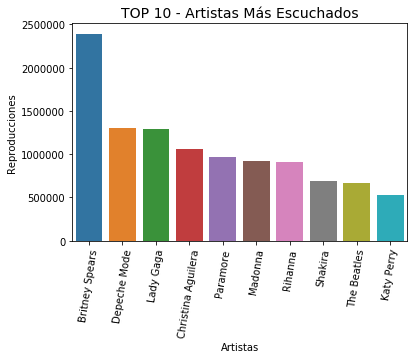

In [6]:
# Completar...
artists_weight = user_artist_plays_data.groupby(['name'], sort=True).sum().reset_index()
artists_weight = artists_weight.sort_values(by=['weight'], ascending=[False]).head(10)
plt.title("TOP 10 - Artistas Más Escuchados", fontsize=14)
ax = sns.barplot(x='name', y='weight', data=artists_weight)
plt.xlabel('Artistas')
plt.xticks(rotation=81)
plt.ylabel('Reproducciones')

In [7]:
#SUMO weight y lo agrupo por usuario
users_weight = user_artist_plays_data.groupby(['userID'], sort=True).sum().reset_index()
users_weight = users_weight.drop(columns="artistID")
users_weight.head()

userID  weight
0       2  168737
1       3   20501
2       4   26930
3       5   13159
4       6    1011

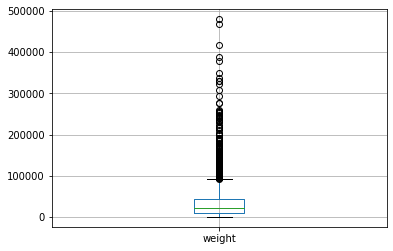

In [8]:
boxplot = users_weight.boxplot(column=['weight'])

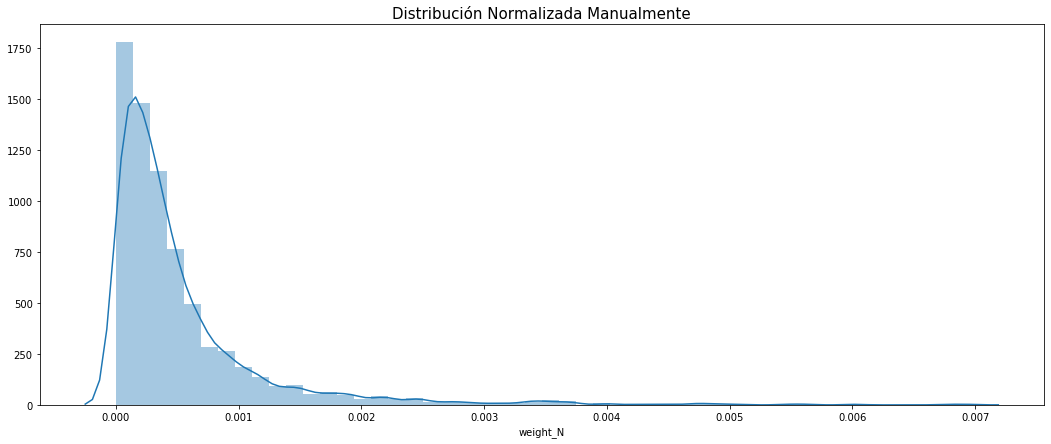

In [9]:
users_weight = users_weight.groupby(['userID'], sort=True).sum()
#users_weight.join(total_weight)
total_weight = users_weight[['weight']].sum().values.astype(float)
users_weight['weight_N'] = users_weight['weight'] / total_weight
#users_weight
plt.figure(figsize = (18, 7))

plt.title('Distribución Normalizada Manualmente', fontsize = 15)
sns.distplot(users_weight.weight_N)

In [10]:
users_weight.index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2099, 2100],
           dtype='int64', name='userID', length=1892)

In [11]:
#ax = sns.barplot(x=users_weight.index, y='weight', data=users_weight)

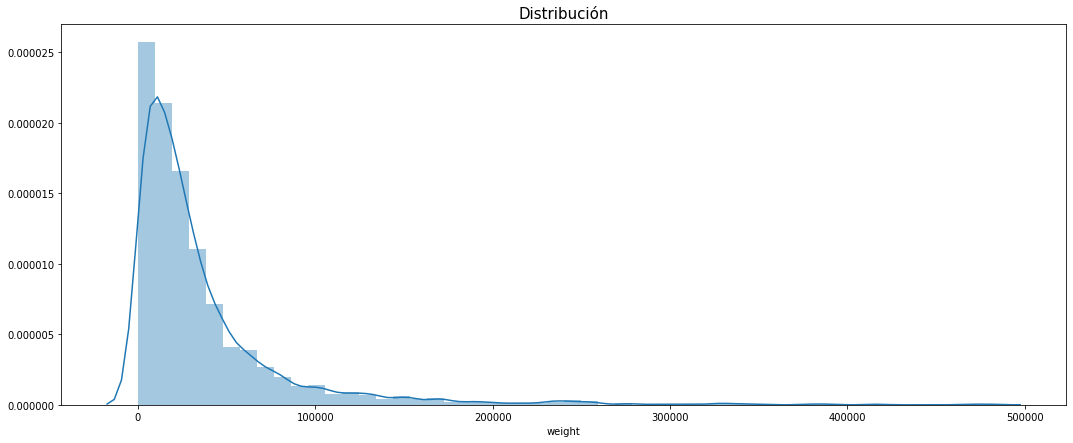

In [12]:
plt.figure(figsize = (18, 7))

plt.title('Distribución', fontsize = 15)
sns.distplot(users_weight.weight)

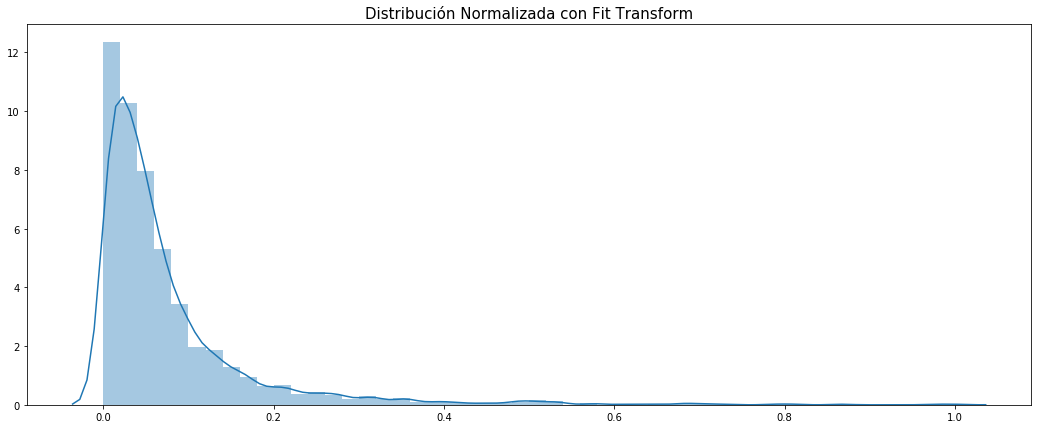

In [13]:
# Create x, where x the 'weight' column's values as floats
x = users_weight[['weight']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
# View the dataframe

plt.figure(figsize = (18, 7))

plt.title('Distribución Normalizada con Fit Transform', fontsize = 15)
sns.distplot(df_normalized)

In [14]:
tags = pd.read_csv("./data/lastfm/tags.dat", sep="\t", encoding = "iso-8859-1")
user_taggedartists = pd.read_csv("./data/lastfm/user_taggedartists.dat", sep="\t")
user_artits = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")
user_taggedartists = user_taggedartists.join(tags.set_index("tagID"), on=["tagID"])
user_taggedartists = pd.merge(user_taggedartists, user_artits, on=['artistID','userID'])
user_taggedartists = user_taggedartists.drop(columns=["userID", "artistID", "day", "month", "year"])
user_taggedartists = user_taggedartists.groupby(['tagID', 'tagValue'], sort=True).mean().reset_index()
user_taggedartists = user_taggedartists.sort_values(by=['weight'], ascending=[False]).head(10)
user_taggedartists

tagID           tagValue    weight
7889  12553  international pop  324663.0
7888  12552         latin diva  324663.0
7886  12550                kot  324663.0
3653   5166       sexy as hell  172496.0
3731   5280              shaki  169596.0
3730   5279       belly dancer  169596.0
3733   5282  best dancer alive  169596.0
3732   5281      most talented  169596.0
1879   2566            remixes  162568.0
2978   4109              lenda  131733.0

## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [15]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    artist_mapper = dict(zip(np.unique(df["artistID"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["weight"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays)

In [16]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.28%


In [17]:
n_listened_per_user = X.getnnz(axis=1)

print(f"Most active user listened {n_listened_per_user.max()} artists.")
print(f"Least active user listened {n_listened_per_user.min()} artists.")

Most active user listened 50 artists.
Least active user listened 1 artists.


In [18]:
n_listened_per_artist = X.getnnz(axis=0)

print(f"Most listened artist has {n_listened_per_artist.max()} listen.")
print(f"Least listened artist has {n_listened_per_artist.min()} listed.")

Most listened artist has 611 listen.
Least listened artist has 1 listed.


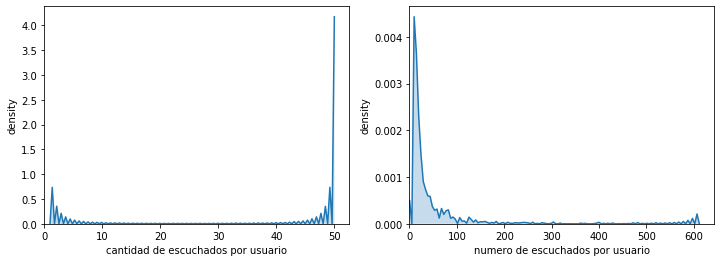

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(n_listened_per_user, shade=True)
plt.xlim(0)
plt.xlabel("cantidad de escuchados por usuario")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_listened_per_artist, shade=True)
plt.xlim(0)
plt.xlabel("numero de escuchados por usuario")
plt.ylabel("density")
plt.show()

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [20]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse

# basic algorithms
from surprise import NormalPredictor, BaselineOnly

# k-NN algorithms
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

# matrix factorization-based algorithms
from surprise import SVD, SVDpp, NMF

# other algorithms
from surprise import SlopeOne, CoClustering


In [21]:
# definimos rango de valores
min_scale = min( user_artist_plays['weight'] )
max_scale = max( user_artist_plays['weight'] )
print( min_scale, max_scale )

1 352698


In [22]:
reader = Reader(rating_scale = (min_scale, max_scale))
uap = Dataset.load_from_df(user_artist_plays, reader)

In [23]:
models = [NormalPredictor(), BaselineOnly(),
          KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(),
          SVD(), SVDpp(), NMF(),
          SlopeOne()]#, CoClustering()]

In [24]:

benchmark = []

# Iterate over all algorithms
for model in models:

    print('Modelo:', str(model).split(' ')[0].split('.')[-1] )
    
    # Perform cross validation
    results = cross_validate( model, uap, measures=['RMSE', 'MAE'], cv=3, verbose = True )
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean( axis = 0 )
    tmp = tmp.append(pd.Series( [ str(model).split(' ')[0].split('.')[-1] ], index=['Model'] ) )
    benchmark.append(tmp)
    
    print('')

Modelo: NormalPredictor
Evaluating RMSE, MAE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4460.92644752.44414650.38604621.2522120.7814
MAE (testset)     2128.14492036.72042092.73982085.868437.6388 
Fit time          0.10    0.12    0.12    0.11    0.01    
Test time         0.30    0.34    0.29    0.31    0.02    

Modelo: BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2933.04634427.46393486.53263615.6809616.8903
MAE (testset)     699.4804705.7505702.8116702.68082.5614  
Fit time          0.30    0.30    0.31    0.30    0.00    
Test time         0.25    0.27    0.17    0.23    0.04    

Modelo: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


In [25]:
surprise_results = pd.DataFrame(benchmark).set_index('Model').sort_values('test_rmse')
surprise_results

test_rmse       test_mae   fit_time  test_time
Model                                                              
BaselineOnly       3615.680893     702.680830   0.302283   0.230269
SlopeOne           3741.876157     790.051775   4.794017   0.996530
NMF                3802.661158     770.391355   4.815766   0.242745
KNNWithMeans       4301.944464     825.804741   0.335763   2.639709
KNNBasic           4306.714367     785.929622   0.318736   2.500545
KNNBaseline        4345.893878     751.630017   0.603979   3.036084
KNNWithZScore      4502.787090     844.931865   0.434746   2.822653
NormalPredictor    4621.252212    2085.868365   0.113001   0.312571
SVDpp            351961.395929  351930.126788  29.734054   1.457842
SVD              351961.396283  351930.127120   3.441992   0.261831

## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [26]:
from sklearn.neighbors import NearestNeighbors

def find_similar_artist(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [27]:
artist_data = pd.read_csv("./data/lastfm/artists.dat", sep="\t")
artist_id_title = dict(zip(artist_data['id'], artist_data['name']))
artist_titles_id = dict(zip(artist_data['name'], artist_data['id']))

user_artist_plays = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays)

musico = "Bob Marley"
artist_id = artist_titles_id[musico]

In [28]:
similar_artist = find_similar_artist(artist_id, X, artist_mapper, artist_inv_mapper, metric='cosine', k=10)
artist_title = artist_id_title[artist_id]

print(f"Porque te gustó {musico}..\n")
for i in similar_artist:
    print(artist_id_title[i])

Porque te gustó Bob Marley..

Nneka
The Brothers Martin
Deluka
Blasted Mechanism
Subkulture
The Pistolas
King Black Acid
Chester Bennington
peixe : avião


Cambiemos la distancia coseno por otra métrica y veamos los resultados:

In [29]:
similar_artist = find_similar_artist(artist_id, X, artist_mapper, artist_inv_mapper, metric='euclidean', k=10)
artist_title = artist_id_title[artist_id]

print(f"Porque te gustó {musico}..\n")
for i in similar_artist:
    print(artist_id_title[i])

Porque te gustó Bob Marley..

Chester Bennington
Skepta
Susan Tedeschi
The Derek Trucks Band
The Parlor Mob
The Brothers Martin
The Allman Brothers Band
Elmore James
The Pistolas


In [30]:
similar_artist = find_similar_artist(artist_id, X, artist_mapper, artist_inv_mapper, metric='manhattan', k=10)
artist_title = artist_id_title[artist_id]

print(f"Porque te gustó {musico}..\n")
for i in similar_artist:
    print(artist_id_title[i])

Porque te gustó Bob Marley..

Susan Tedeschi
The Derek Trucks Band
Skepta
Ollabelle
Duane Allman
The Pioneers
The Offenders
Toots and the Maytals
The Bronx
